In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def create_dataset(df, look_back=10):
    X, Y = [], []
    for i in range(len(df) - look_back):
        X.append(df[i:i + look_back, 0])
        Y.append(df[i + look_back, 0])
    return np.array(X), np.array(Y)

In [3]:
companies = ["WIPRO-imputated.csv", "TCS.csv", "INFY.csv", "HCLTECH.csv"]
company_names = ["WIPRO", "TCS", "INFY", "HCLTECH"]

In [4]:
def create_model(look_back):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
look_back = 20
future_steps = 10

In [6]:
model = create_model(look_back)

WIPRO-imputated.csv
Epoch 1/10
1456/1456 - 18s - loss: 0.0058 - 18s/epoch - 12ms/step
Epoch 2/10
1456/1456 - 14s - loss: 0.0034 - 14s/epoch - 10ms/step
Epoch 3/10
1456/1456 - 14s - loss: 0.0029 - 14s/epoch - 10ms/step
Epoch 4/10
1456/1456 - 16s - loss: 0.0027 - 16s/epoch - 11ms/step
Epoch 5/10
1456/1456 - 17s - loss: 0.0022 - 17s/epoch - 12ms/step
Epoch 6/10
1456/1456 - 15s - loss: 0.0023 - 15s/epoch - 10ms/step
Epoch 7/10
1456/1456 - 15s - loss: 0.0028 - 15s/epoch - 10ms/step
Epoch 8/10
1456/1456 - 16s - loss: 0.0016 - 16s/epoch - 11ms/step
Epoch 9/10
1456/1456 - 14s - loss: 0.0021 - 14s/epoch - 9ms/step
Epoch 10/10
1456/1456 - 16s - loss: 0.0019 - 16s/epoch - 11ms/step
46/46 [==============================] - 2s 11ms/step


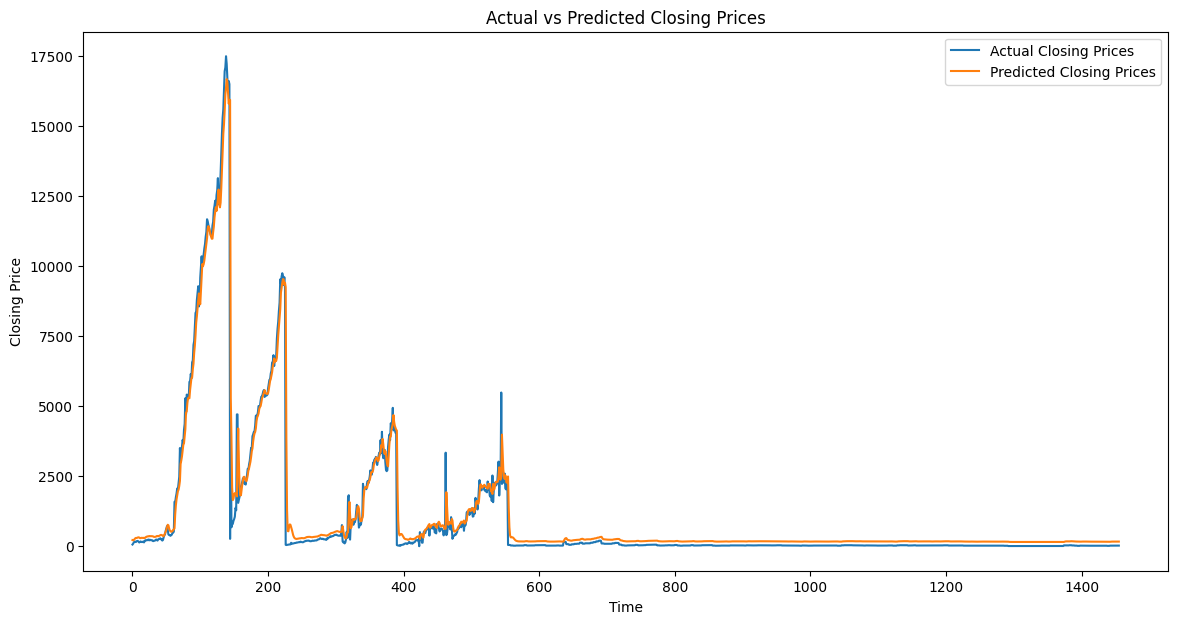

TypeError: in user code:

    File "d:\dev\ml\venv\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "d:\dev\ml\venv\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\dev\ml\venv\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "d:\dev\ml\venv\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "d:\dev\ml\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\dev\ml\venv\lib\site-packages\keras\src\layers\rnn\lstm.py", line 616, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [7]:
for idx, (company, name) in enumerate(zip(companies, company_names)):
    print(company)
    df = pd.read_csv(f"../datasets/{company}")
    closing_prices = df.iloc[:, 1:].values.astype(float)

    scaler = MinMaxScaler(feature_range=(0, 1))
    closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))

    X, Y = create_dataset(closing_prices_scaled, look_back)

    if idx == 0:
        model.fit(X, Y, epochs=10, batch_size=1, verbose=2)
    else:
        model.fit(X, Y, epochs=5, batch_size=1, verbose=2)

    predicted_closing_prices_scaled = model.predict(X)
    predicted_closing_prices = scaler.inverse_transform(predicted_closing_prices_scaled)
    actual_closing_prices = scaler.inverse_transform(closing_prices_scaled[look_back:])

    plt.figure(figsize=(14, 7))
    plt.plot(actual_closing_prices, label='Actual Closing Prices')
    plt.plot(predicted_closing_prices, label='Predicted Closing Prices')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.title('Actual vs Predicted Closing Prices')
    plt.legend()
    plt.show()

    last_sequence = closing_prices_scaled[-look_back:]
    
    future_predictions = []
    for _ in range(future_steps):
        next_pred = model.predict(last_sequence.reshape(1, look_back, 1))
        future_predictions.append(next_pred[0, 0])
        last_sequence = np.append(last_sequence[1:], next_pred)[-look_back:].reshape(look_back, 1)
    
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    plt.figure(figsize=(14, 7))
    plt.plot(actual_closing_prices, label='Actual Closing Prices')
    plt.plot(predicted_closing_prices, label='Predicted Closing Prices')
    plt.plot(np.arange(len(actual_closing_prices),
                       len(actual_closing_prices) + future_steps), future_predictions, label='Future Predictions', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.title('Actual vs Predicted Closing Prices and Future Predictions')
    plt.legend()
    plt.show()
    mse = mean_squared_error(actual_closing_prices, predicted_closing_prices)
    mae = mean_absolute_error(actual_closing_prices, predicted_closing_prices)
    r2 = r2_score(actual_closing_prices, predicted_closing_prices)
    
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R-squared: {r2}")
